# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [6]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\cosmi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [7]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import statistics
from matplotlib import animation

from genepro.variation import subtree_crossover
from genepro.variation  import subtree_mutation
from genepro.variation import coeff_mutation
from genepro.selection import tournament_selection

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [8]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [9]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [10]:
frames = []
seeds = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [11]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False, seed = -1):
  memory = ReplayMemory(10000)
  rewards = []
  wins = 0
  games = 0
  episodes =  num_episodes+difficulty
  for i in range(episodes):
    # get initial state of the environment
    if(seed == -1):
      observation = env.reset(seed=seeds[i])
    else :
      observation = env.reset(seed=seed)
    
    observation = observation[0]
    currentReward = 0
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      currentReward = currentReward+reward
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break
    if (currentReward > 200):
      wins+=1
      currentReward = 200
    games = games + 1
    rewards.append(currentReward)
    
  #fitness = int((multitree.wins*100/multitree.games))*1000 + np.sum(rewards) / (num_episodes+difficulty)
  
  percentage = (multitree.wins+wins)/(multitree.games+games)
  extraPoints = (int((percentage)*100))*1000
  
  fitness = np.sum(rewards) / (episodes)
  if(percentage>=2):
    fitness = fitness+extraPoints
  
  return fitness, memory, wins, games


def initSeeds(start = False):
  global seeds
  global seedsNumber
  global difficulty
  if(start):
    if(difficulty<2):
      difficulty = difficulty + 1
      print(f"Increasing difficulty to {difficulty}")
  
  seeds = [np.random.randint(32000) for _ in range(20)]
  print(f"seeds: {seeds}")
  return difficulty+5

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [12]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div(),Sqrt(), Sin(), Max(), Min()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=120,
  max_gens=300,
  max_tree_size=70,
  crossovers=[{"fun": subtree_crossover, "rate": 0.5}],
  mutations=[{"fun": subtree_mutation, "rate": 0.5}],
  coeff_opts =[{"fun":coeff_mutation, "rate": 0.4}],
  selection ={"fun":tournament_selection,"kwargs":{"tournament_size":10}},
  n_jobs=8,
  verbose=True,
  elitism=0.02
)

## Evolve
Running this cell will use all the settings above as parameters

In [13]:
seeds = []
evo.initSeeds = initSeeds
difficulty = 0
evo.evolve()

KeyboardInterrupt: 

In [ ]:
import tempfile

with tempfile.NamedTemporaryFile(delete=False) as temp_file:
    #temp_file.write(b'Test content')
    print(f"Temporary file created at: {temp_file.name}")
    pickle.dump(best, temp_file)

Temporary file created at: C:\Users\cosmi\AppData\Local\Temp\tmp_h6i_rh6


In [14]:
# Save model
import pickle

file_path = 'best_gp.pickle'

# Open the file in binary mode
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(evo.best_of_gens[-1], file)

IndexError: list index out of range

In [ ]:
#Save population
import pickle

file_path = 'best_evo_population.pickle'

# Open the file in binary mode
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(evo, file)

OSError: [Errno 22] Invalid argument: 'best_evo_population.pickle'

In [20]:
#Load saved model
import pickle
file_path = 'best_gp.pickle'
with open(file_path, 'rb') as file:
    best = pickle.load(file)
    evo.best_of_gens.append(best)

UnpicklingError: pickle data was truncated

In [ ]:
#Load saved population
import pickle
#Load saved model
file_path = 'best_evo_population.pickle'
with open(file_path, 'rb') as file:
    evo = pickle.load(file)

C:\Users\cosmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cosmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\cosmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


AttributeError: Can't get attribute 'fitness_function_pt' on <module '__main__'>

# Test

In [ ]:
def get_test_score(tree):
    rewards = []
    episodeNumber = 100
    goodRuns = 0
    badRuns = 0
    for i in range(episodeNumber):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]
      currentReward = 0
      for j in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(tree.get_output_pt(input_sample))
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)
        currentReward += reward
        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break
      if(currentReward > 200):
        goodRuns+=1
      else:
        badRuns+=1
      print(f"{i} , {currentReward}")
    fitness = np.sum(rewards)
    
    return fitness / episodeNumber, goodRuns,goodRuns+badRuns

best = evo.population[52]
difficulty = 0
print(best.get_readable_repr())
score, goodRuns,totalRuns = get_test_score(best)
print(f"Score is {score}" )
print(f"Good runs {goodRuns}/{totalRuns}")

['(max((min((sin(x_3)+x_4),max(((max(min(sin((x_1-x_1)),x_4),min((x_3+(x_4/x_7)),sin(x_2)))/x_3)+sqrt(abs((x_7-x_7)))),sin(-4.0555276010719306)))/sqrt(abs(sin(sin((min(x_7,x_4)-sin(max(max(x_0,max(max(min(sin(sqrt(abs((1.2477985620498657+sqrt(abs(sin(x_5))))))),x_0),x_0),x_6)),sin(x_3))))))))),sin(x_3))-sin(sin((min(x_7,x_4)-sin(x_1)))))', '((sqrt(abs((x_1-x_7)))/min(x_7,(x_1-x_7)))*(((sin(0.28321325276849085)-x_0)*x_0)-min((((sin(0.38596226472274564)/min(x_7,(x_1-x_7)))-x_7)-max(min((x_6*max(x_7,x_7)),(max(x_5,x_4)*3.6109756237236263)),sin((max(((x_4+x_4)*x_2),max(x_3,x_0))/(min(sin(x_7),(x_5/x_7))*sin((max(x_5,x_4)*3.6109756237236263))))))),x_4)))', '((min(max(sin(sqrt(abs(x_4))),max(x_6,x_0)),sqrt(abs(x_5)))*max((sin(min(x_4,(x_0-x_7)))*(sin(x_4)*(max(sqrt(abs(sqrt(abs(sqrt(abs(max(sqrt(abs(x_5)),x_3))))))),x_7)+((min(x_4,x_1)*(x_2-(x_2-x_6)))/(max(x_5,x_4)*(x_4/min(x_3,x_2))))))),sin((sqrt(abs(x_3))/sqrt(abs(3.020122528076172))))))*sqrt(abs((((1.2002949714660645*(x_6+x_6))*x_3)-sqr

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

seeds: [27889, 982, 17270, 9661, 14477, 2590, 28646, 15524, 8464, 26287, 29969, 24245, 31588, 25512, 11261, 5473, 26912, 669, 16085, 7618]


MovieWriter imagemagick unavailable; using Pillow instead.


OSError: [Errno 22] Invalid argument: './evolved_lander.gif'

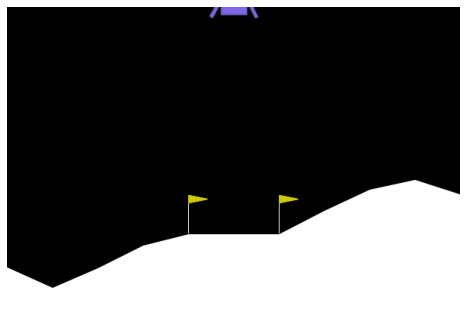

In [ ]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
initSeeds()
#Please check the seed to the right
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False, seed=12699  )
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

### Question 3

Bring more elaborated ideas (also taking inspiration from the scientific literature) about how the provided GP library could be improved using coefficient optimisation. Optimisation can be expensive, so consider what individuals or what portion of the population should be optimised. Important: At this stage, each idea should be formalised into a motivating hypothesis (e.g., “Assuming that . . . happens, then we expect an improvement by doing . . . ”.

---

## Jack

The optimization can be done periodically while evolving as well. For example: optimizing the best multitree coefficients of every generation, or every x generations.

Some potentially useful papers
1. Genetic Programming and Reinforcement Learning on Learning Heuristics for Dynamic Scheduling: A Preliminary Comparison (https://www.researchgate.net/publication/380254508_Genetic_Programming_and_Reinforcement_Learning_on_Learning_Heuristics_for_Dynamic_Scheduling_A_Preliminary_Comparison)
2. Reinforced Genetic Programming (https://link.springer.com/article/10.1023/A:1011953410319)
3. Multi-modal multi-objective model-based genetic programming to find multiple diverse high-quality models (https://arxiv.org/pdf/2203.13347)
4. Multi-objective Genetic Programming Optimization of Decision Trees for Classifying Medical Data (https://link.springer.com/chapter/10.1007/978-3-540-45224-9_42)
5. Coefficient Mutation in the Gene-pool Optimal Mixing Evolutionary Algorithm for Symbolic Regression (https://dl.acm.org/doi/pdf/10.1145/3520304.3534036)

Mind here: programs in this case = multitrees

Ideas:
1. Optimizing coefficients of the best multitree of each generation during evolution. Assuming that we optimize the coefficients of the best individual in a population, increasing the fitness, its offspring will also be fitter. We expect an improvement in "convergence rate" (fitness improves faster). This does not affect the global structure of the trees but the coefficients get "propagated"
2. The same, but not the best of every generation to save compute.
3. Optimize the coefficients on the worst individuals. Assume that the fitness increases to the point that the program will be included in the tournament selection. Then, this program is "saved" from being eliminated, and will perhaps evolve into a good (or best) solution. This is kind of like exploration, avoiding a pure greedy approach.
4. Same reasoning for optimizing the number 2 or 3, or multiple programs, but that will be very expensive so probably not good.
5. Inspired by paper: Coefficient Mutation in the Gene-pool Optimal Mixing Evolutionary Algorithm (GOMEA). Use Gaussian coefficient mutation to mutate the coefficients to allow for more exploration, and fine-tuning solutions. This could be combined with optimizing while evolving for example. E.g. optimizing the best program and mutating it using gaussian coefficient mutation to create new programs. Then see if these programs are among the highest fitness to be selected by tournament selection. Assuming that this propagates the best solution while also exploring the solution (program) space, then this will ultimately lead to an overall better solution.
6. Inspired by: Multi-objective Genetic Programming Optimization of Decision Trees for Classifying Medical Data. Use this technique that they are using to enhance their GP's coefficient optimization properties. But right now I don't have enough time to figure out what they did. ### TODO: LOOK AT PAPER. They state this: "We have incorporated a Quasi-Newton optimization technique to augment the
power ofthe GP coefficient optimization. This technique uses an error propaga-
tion algorithm that efficiently calculates the gradient ofthe error function with
respect to the coefficients embedded in the GP expression tree"

In [ ]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

['(max((min((sin(x_3)+x_4),max(((max(min(sin((x_1-x_1)),x_4),min((x_3+(x_4/x_7)),sin(x_2)))/x_3)+sqrt(abs((x_7-x_7)))),sin(nan)))/sqrt(abs(sin(sin((min(x_7,x_4)-sin(max(max(x_0,max(max(min(sin(sqrt(abs((1.2415639162063599+sqrt(abs(sin(x_5))))))),x_0),x_0),x_6)),sin(x_3))))))))),sin(x_3))-sin(sin((min(x_7,x_4)-sin(x_1)))))', '((sqrt(abs((x_1-x_7)))/min(x_7,(x_1-x_7)))*(((sin(nan)-x_0)*x_0)-min((((sin(nan)/min(x_7,(x_1-x_7)))-x_7)-max(min((x_6*max(x_7,x_7)),(max(x_5,x_4)*nan)),sin((max(((x_4+x_4)*x_2),max(x_3,x_0))/(min(sin(x_7),(x_5/x_7))*sin((max(x_5,x_4)*nan))))))),x_4)))', '((min(max(sin(sqrt(abs(x_4))),max(x_6,x_0)),sqrt(abs(x_5)))*max((sin(min(x_4,(x_0-x_7)))*(sin(x_4)*(max(sqrt(abs(sqrt(abs(sqrt(abs(max(sqrt(abs(x_5)),x_3))))))),x_7)+((min(x_4,x_1)*(x_2-(x_2-x_6)))/(max(x_5,x_4)*(x_4/min(x_3,x_2))))))),sin((sqrt(abs(x_3))/sqrt(abs(nan))))))*sqrt(abs((((nan*(x_6+x_6))*x_3)-sqrt(abs(x_6))))))', '(max((((x_6/x_7)-min(x_6,x_2))+((x_5+x_4)+x_4)),((x_4*x_3)+(x_3+(x_3/x_3))))/min(((max(x

MovieWriter imagemagick unavailable; using Pillow instead.


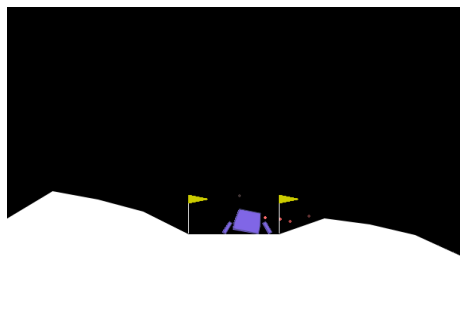

In [ ]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">